In [2]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.stats import gaussian_kde
from scipy import stats as scipystats
from scipy import signal, interpolate
from scipy.interpolate import interp1d
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from functools import reduce

from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES
from analysis.processing.epochs import get_epochs
from analysis.plots.utils import get_figure_size, get_extent
from analysis.models.analytics import gaussian_kernel_2D

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def get_trajectory_in_arena_rf(h5file):
    with h5py.File(h5file, 'r') as f:
        trajectory = np.array(f['animal_trajectory'])
        arena_trajectory = np.array(f['arena_trajectory'])

    # bring to arena coordinate system
    a_min, a_max = arena_trajectory[:, 2].min(), arena_trajectory[:, 2].max()
    arena_trajectory[:, 2] -= a_min
    trajectory[:, 2] -= arena_trajectory[:len(trajectory), 2] - ( (a_max - a_min)/2 )
    
    return trajectory

In [5]:
def get_occ_and_speed(sessions_list, bin_size=0.03):
    # get a session for common variables
    animal, session = sessions_list[0][0], sessions_list[0][1]
    occupancies = []
    speeds = []

    # use first session to get common params
    trajectory = get_trajectory_in_arena_rf(os.path.join(source, animal, session, 'all.h5'))
    conditions = get_epochs(os.path.join(source, animal, session))

    kernel = gaussian_kernel_2D(0.1)
    
    # let's set the same for all
    #limits = get_figure_size(trajectory[:, 1:3])
    #extent = get_extent(trajectory[:, 1:3])
    #x_min, x_max = trajectory[:, 1].min(), trajectory[:, 1].max()
    #y_min, y_max = trajectory[:, 2].min(), trajectory[:, 2].max()
    
    extent = (-0.4, 0.4, -0.85, 0.85)
    limits = (extent[0] - 0.1, extent[1] + 0.1, extent[2] - 0.1, extent[3] + 0.1)
    x_min, x_max, y_min, y_max = extent
    
    pos_range = np.array([[x_min, x_max], [y_min, y_max]])

    x_range = x_max - x_min
    y_range = y_max - y_min
    y_bin_count = int(np.ceil(y_range / bin_size))
    x_bin_count = int(np.ceil(x_range / bin_size))

    for animal, session, s_type in [s for s in sessions_list]:
        sessionpath = os.path.join(source, animal, session)
        conditions = get_epochs(sessionpath)
        h5file = os.path.join(sessionpath, 'all.h5')

        if not os.path.exists(h5file):
            continue

        trajectory = get_trajectory_in_arena_rf(h5file) 
        sampling_rate = float(round((np.ones(len(trajectory) - 1)/np.diff(trajectory[:, 0])).mean()))

        occup_temp = {}
        speed_temp = {}
        for i, cond in enumerate(conditions):
            with h5py.File(h5file, 'r') as f:
                cond_idxs = np.array(f['%s_idxs' % cond])
                velocity = np.array(f['velocity'])
                velocity = np.append(velocity, [velocity[-1]], axis=0)
                #trajectory = np.array(f['animal_trajectory'])[:, 3]  # t, x, y

            #diffs = np.diff(trajectory[:, :3], axis=0)
            #velocity_Y = diffs[:, 2] / diffs[:, 0]  # dy/dt, only Y-component of the velocity
            #velocity_Y = np.sqrt(np.square(diffs[:, 1]) + np.square(diffs[:, 2])) / diffs[:, 0]  # real velocity
            #velocity_Y = np.append(velocity_Y, 0)
            #weights = velocity_Y[cond_idxs]
            
            pos = trajectory[cond_idxs]
            weights = velocity[cond_idxs][:, 1]  # real velocity
            
            occup, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], range=pos_range)
            speed, _, _ = np.histogram2d(pos[:, 1], pos[:, 2], bins=[x_bin_count, y_bin_count], density=True, weights=weights, range=pos_range)

            occup_temp[cond] = occup / sampling_rate
            #print(sampling_rate, len(pos)/(60.*sampling_rate), len(trajectory)/(60.*sampling_rate), occup_temp[cond].sum())
            #speed_temp[cond] = np.nan_to_num(speed/occup_temp[cond])
            speed_temp[cond] = speed/occup_temp[cond]

        occupancies.append(occup_temp)
        speeds.append(speed_temp)

    # sum across sessions within each condition
    occ_all = {}
    for cond in conditions:
        selection = [occ[cond] for occ in occupancies if cond in occ]
        occ_sum = reduce((lambda x, y: x + y), selection)
        occ_all[cond] = occ_sum/len(selection)

    speed_all = {}
    for cond in conditions:
        colnan = [sp[cond] for sp in speeds if cond in sp]

        result = []
        n, m = np.array(colnan[0]).shape
        for i in range(n):
            for j in range(m):
                result.append(np.nanmean( [x[i, j] for x in colnan] ))

        result = np.array(result)
        result[np.isnan(result)] = 0.
        result = np.reshape(np.array(result), (-1, m))        
        
        #speed_all[cond] = sp_sum/len(selection)        
        speed_all[cond] = result/float(len(colnan))
        
    return conditions, occ_all, speed_all, extent, limits

In [6]:
def plot_arena_stats(maps, extent, limits, titles, hlines=[]):
    fig = figure(figsize=(2*len(maps), 3))
    kernel = gaussian_kernel_2D(0.1)

    vmax = np.array([signal.convolve2d(occ, kernel, mode='same').max() for occ in maps.values()]).max()
    collected = []
    for i, cond in enumerate(sorted(maps.keys())):
        occupancy_map = maps[cond]
        occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same')

        ax = fig.add_subplot(1, len(maps.keys()), i+1)
        ax.set_xticks([])
        if i > 0:
            ax.set_yticklabels([])

        ax.set_xlim(limits[0], limits[1])
        ax.set_ylim(limits[2], limits[3])
        ax.grid()
        ax.set_title(titles[i], fontsize=14)
        #ax.set_xlabel('X, m', fontsize=14)
        #if i == 0:
        #    ax.set_ylabel('Y, m', fontsize=14)
            
        for hline in hlines:
            ax.axhline(hline, color=COLORS['a'], ls='--')

        #ax.axhspan(-0.3, 0.3, alpha=0.1, color=COLORS['a'])
        
        posPFA = ax.imshow(occupancy_map.T, cmap='jet', origin='lower', extent=extent, vmax=vmax)
        collected.append(occupancy_map.T)

    cax = fig.add_axes([ax.get_position().x1 + 0.02, ax.get_position().y0, 0.01, ax.get_position().height])
    cbar = plt.colorbar(posPFA, cax=cax) # Similar to fig.colorbar(im, cax = cax)
    cbar.set_label('Speed, m/s', fontsize=14)
    
    return collected

In [7]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
#source = '/storage2/andrey/data/processed'
paper = '/home/andrey/storage2/andrey/data/projects/24_shift/PAPER'
#paper = '/storage2/andrey/data/projects/24_shift/paper'
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']  # no '002784'

In [8]:
names_short = {
    'SHIFT periodic +dark': 'P',
    'SHIFT single +dark': 'S',
    'SHIFT both +dark': 'C',
    'SHIFT visual +dark': 'Vs',
    'SHIFT visual long +dark': 'Vl',
    'GAIN 3 parts 1.2x': 'Gs',
    'GAIN 3 parts 1.4x': 'Gl'
}
early_per = get_sessions_list(source, animals, 'SHIFT periodic')
early_per.remove(['00908', '2019-07-08_17-46-20', 'SHIFT periodic'])  # broken session
periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
single = get_sessions_list(source, animals, 'SHIFT single +dark')
coherent = get_sessions_list(source, animals, 'SHIFT both +dark')
visual_s = get_sessions_list(source, animals, 'SHIFT visual +dark')  # these are all periodic!
visual_l = get_sessions_list(source, animals, 'SHIFT visual long +dark')  # these could be per / single
gain_12 = get_sessions_list(source, animals, 'GAIN 3 parts 1.2x')
gain_14 = get_sessions_list(source, animals, 'GAIN 3 parts 1.4x')  # 003281, 003282 - remove completely? wrong gain

### single sessions 2D maps

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


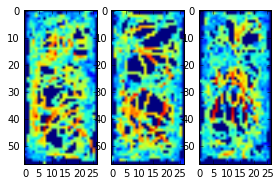

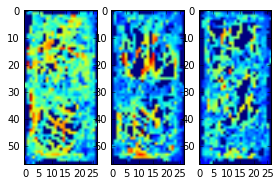

In [10]:
titles = ['Original', 'Shifted', 'Dark']
#titles = ['Original', 'Gain', 'Shifted', 'Dark']

selection = periodic
selection = periodic + single
#selection = single
selection = visual_s
#selection = gain_14
#selection = early_per
for i, session in enumerate(selection[:2]):
    conditions, occs, speeds, extent, limits = get_occ_and_speed([session])
    
    # merge dark into one condition
    if 'Ad' in conditions:
        conditions = ('A', 'B', 'D')
        speeds['D'] = speeds['Ad']/2# + speeds['Bd']
        del speeds['Ad']
        del speeds['Bd']
    
    #maps_plotted = plot_arena_stats(speeds, extent, limits, titles)
    
    fig = figure(figsize=(6, 3))
    for j, cond in enumerate(conditions):
        ax = fig.add_subplot(1, 4, j+1)
        ax.imshow(speeds[cond].T)

### Average 2D maps by animal

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


[['003908', 15], ['003909', 2], ['005363', 3], ['005364', 2]]


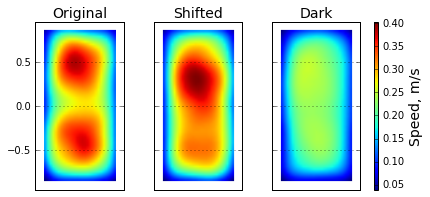

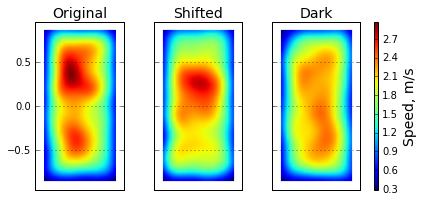

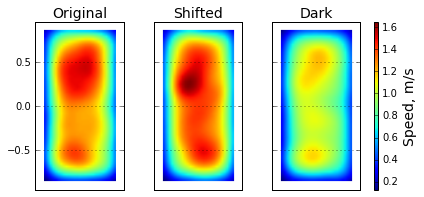

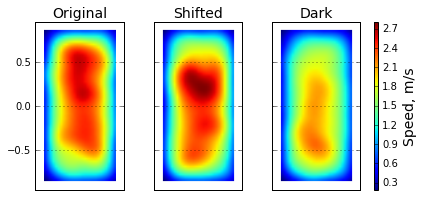

In [9]:
titles = ['Original', 'Shifted', 'Dark']
#titles = ['Original', 'Gain', 'Shifted', 'Dark']

anim_stats = []
#selection = periodic
#selection = periodic + single
selection = visual_s
#selection = gain_14
#selection = early_per
for i, animal in enumerate(animals):
    ss = [x for x in selection if x[0] == animal]
    if len(ss) == 0:
        continue
    conditions, occs, speeds, extent, limits = get_occ_and_speed(ss)
    
    # merge dark into one condition
    if 'Ad' in conditions:
        conditions = ('A', 'B', 'D')
        speeds['D'] = speeds['Ad']/2# + speeds['Bd']
        del speeds['Ad']
        del speeds['Bd']
    
    maps_plotted = plot_arena_stats(speeds, extent, limits, titles)
    anim_stats.append([animal, len(ss)])
    
print(anim_stats)

### Y-Profiles

/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/home/andrey/.local/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


['005364', '2020-10-23_12-57-03', 'SHIFT single +dark']
[['00908', 98]]


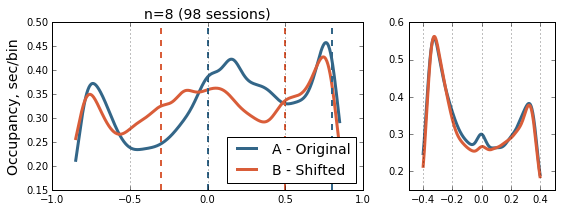

In [22]:
selection = periodic + single + early_per
#selection = periodic
#selection = single
#selection = visual_s
#selection = gain_14
#selection = early_per
kernel_1D = signal.gaussian(100, std=15)

labels = ('Original A', 'Shifted B', 'Dark D')
labels = ('A - Original', 'B - Shifted')
colors = (COLORS['a'], COLORS['b'], COLORS['e'])
#colors = [COLORS['a'], COLORS['c'], COLORS['b'], '#b1b1b1']
titles = ['Y-profile', 'X-profile (control)']

anim_stats = []
for i, animal in enumerate(animals[:1]):    
    selected_anim = selection
    #selected_anim = [x for x in selection if x[0] == animal]
    if len(selected_anim) == 0:
        continue
    anim_stats.append([animal, len(selected_anim)])
    
    
    #fig = figure(figsize=(15, 3))
    #fig, axs = plt.subplots(1, 2)
    #fig.set_figheight(3)
    #fig.set_figwidth(9)
    fig, axs = plt.subplots(1, 2, gridspec_kw={
        'width_ratios': [extent[3] - extent[2], extent[1] - extent[0]]})
    fig.set_figheight(3)
    fig.set_figwidth(9)

    speed_profiles_X = {}  # each element is a dict {condition, [list of profiles for each session]}
    speed_profiles_Y = {}  # each element is a dict {condition, [list of profiles for each session]}
    for cond in ('A', 'B', 'C', 'D'):
        speed_profiles_X[cond] = []
        speed_profiles_Y[cond] = []
    for ss in selected_anim:
        try:
            conditions, occs, speeds, extent, limits = get_occ_and_speed([ss])
        except:
            print(ss)
            continue

        # merge dark into one condition for periodic
        if 'Ad' in conditions:
            conditions = ('A', 'B', 'D')
            conditions = ('A', 'B')
            #speeds['D'] = speeds['Ad']/2# + occs['Bd']
            del speeds['Ad']
            del speeds['Bd']

        for j, cond in enumerate(conditions):
            #s_map = speeds[cond]
            s_map = occs[cond]
            s_map[s_map==0] = np.nan
            speed_profile_X = np.array([np.nanmean(x) for x in s_map])  # play here with left / right
            speed_profile_Y = np.array([np.nanmean(x) for x in s_map.T])  # play here with left / right
            speed_profile_X[np.isnan(speed_profile_X)] = 0.0
            speed_profile_Y[np.isnan(speed_profile_Y)] = 0.0
            profiles = speed_profiles_X[cond]
            profiles.append(speed_profile_X)
            speed_profiles_X[cond] = profiles
            profiles = speed_profiles_Y[cond]
            profiles.append(speed_profile_Y)
            speed_profiles_Y[cond] = profiles
            
    for j, ax in enumerate(axs):
        profiles = speed_profiles_Y if j == 0 else speed_profiles_X
        if j == 0:
            x_binned = np.linspace(extent[2], extent[3], len(profiles['A'][0]))
        else:
            x_binned = np.linspace(extent[1], extent[0], len(profiles['A'][0]))            
        for q, cond in enumerate(conditions):
            c_profiles = np.array(profiles[cond])
            y_binned = c_profiles.sum(axis=0)/len(c_profiles)
            
            if j == 0:
                x_new = np.linspace(extent[2], extent[3], 500)
            else:
                x_new = np.linspace(extent[1], extent[0], 500)
            f = interp1d(x_binned, y_binned)
            
            y_new = np.concatenate([np.ones(100)*y_binned[0], f(x_new), np.ones(100)*y_binned[-1]])
            y_new = np.convolve(y_new, kernel_1D, 'same') / kernel_1D.sum()
            y_new = y_new[100:-100]
            #y_new = np.convolve(f(x_new), kernel_1D, 'same') / kernel_1D.sum()
            
            ax.plot(x_new, y_new, lw=3, color=colors[q], label=labels[q])
            
            # do interpolation before averaging?
            #a_BSpline = interpolate.make_interp_spline(x_vals_s, occs_avg)
            #y_new = a_BSpline(x_new)
            #y_new = np.convolve(y_new, kernel_1D, 'same') / kernel.sum()
            #ax.plot(x_new, y_new, color=colors[j], lw=3, label=labels[j])
            #ax.plot(x_vals_s, speeds_avg, lw=3, color=colors[j], label=labels[j])

        ax.xaxis.grid()

        lb = 'Y' if j == 0 else 'X'
        #ax.set_title('%s - %s, s=%s, 0.3m' % (lb, animal, len(selected_anim)), fontsize=14)
        #ax.set_title(titles[j], fontsize=14)
        #ax.set_xlabel('%s pos. in arena, m' % lb, fontsize=14)
        if j == 0:
            ax.axvline(0, color=COLORS['a'], lw=2, ls='--') #, label='Virt. walls A')    # virtual walls A
            ax.axvline(0.8, color=COLORS['a'], lw=2, ls='--')  # virtual walls A
            ax.axvline(0 - 0.3, color=COLORS['b'], lw=2, ls='--')#, label='Virt. walls B')    # virtual walls A
            ax.axvline(0.8 - 0.3, color=COLORS['b'], lw=2, ls='--')  # virtual walls A
            #ax.fill_between(x_vals_s[15:41], 0, occ_s_A[15:41], color=COLORS['e'])
            #ax.set_xlabel('Y position in arena, m', fontsize=14)
            ax.set_ylabel('Occupancy, sec/bin', fontsize=14)
            ax.set_ylim(bottom=4)
            ax.set_ylim(0.15, 0.5)
            #ax.set_ylabel('Speed, m/s', fontsize=14)
            ax.set_title("n=8 (98 sessions)", fontsize=14)
            ax.legend(loc='lower right', fontsize=14)
        else:
            ax.set_xlim(-0.5, 0.5)
            
print(anim_stats)

filename = "1e_2.pdf"
fig.savefig(os.path.join(os.path.join(paper), filename))

In [17]:
len(periodic + single + early_per)

98

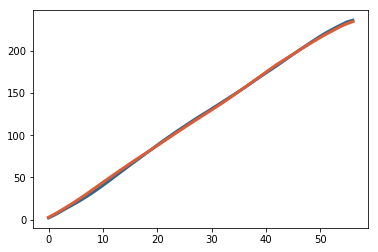

In [26]:
#np.array(speed_profiles_Y['A']).shape

plt.plot(np.array(speed_profiles_Y['A']).mean(axis=0).cumsum(), color=COLORS['a'], lw=3)
plt.plot(np.array(speed_profiles_Y['B']).mean(axis=0).cumsum(), color=COLORS['b'], lw=3)

### Speed histograms

In [25]:
all_types = [early_per, periodic, single, coherent, visual_s, visual_l, gain_12, gain_14]
all_sessions = [j for i in all_types for j in i]

df = pd.DataFrame(columns=['animal', 'exp', 'session', 'condition', 'velocity_hist'])
df['velocity_hist'] = df['velocity_hist'].astype(object)
#df.loc[1, 1] = np.array([5, 6, 7, 8])

bins = np.linspace(0, 1, 20)
for ss in all_sessions:
    sessionpath = os.path.join(source, ss[0], ss[1])
    conditions = get_epochs(sessionpath)
    h5file = os.path.join(sessionpath, 'all.h5')
    if not os.path.exists(h5file):
        continue

    for i, cond in enumerate(conditions):
        with h5py.File(h5file, 'r') as f:
            cond_idxs = np.array(f['%s_idxs' % cond])
            velocity = np.array(f['velocity'])

        vals, edges = np.histogram(velocity[cond_idxs], bins=bins)
        s_type = ss[2] if not ss[2] == 'SHIFT periodic' else 'SHIFT periodic +dark'
        df.loc[len(df)] = [ss[0], names_short[s_type], ss[1], cond, vals]  # adding a row
        
#ker = scipystats.gaussian_kde(df['shift'], bw_method=0.15)
#x_vals = np.linspace(-0.2, 0.5, 100)
#ax.plot(x_vals, 18*ker(x_vals), color=COLORS['b'], lw=3, ls='--')

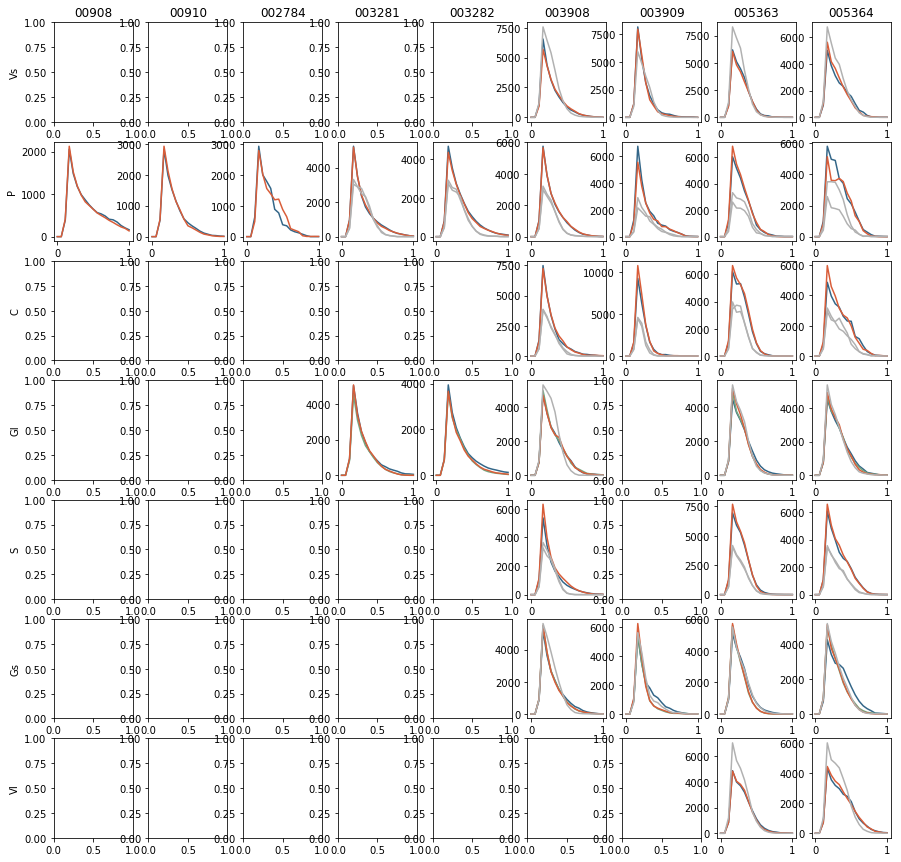

In [30]:
fig, axs = plt.subplots(len(names_short), len(animals))
fig.set_figheight(15)
fig.set_figwidth(15)
colors = {
    'A': COLORS['a'],
    'B': COLORS['b'],
    'C': COLORS['c'],
    'D': '#b1b1b1',
    'Ad': '#b1b1b1',
    'Bd': '#b1b1b1'
}

for i, exp_type in enumerate(names_short.values()):
    for j, animal in enumerate(animals):
        selection = df[(df['animal']==animal) & (df['exp']==exp_type)]
        conditions = selection['condition'].unique()
        
        ax = axs[i][j]
        for q, cond in enumerate(conditions):
            data = selection[selection['condition']==cond]
            dist = np.array([x for x in data['velocity_hist']])
            dist_avg = dist.sum(axis=0)/len(dist)
            ax.plot(np.linspace(0, 1, len(dist_avg)), dist_avg, color=colors[cond])
            
            #ker = scipystats.gaussian_kde(dist_avg, bw_method=0.15)
            #x_vals = np.linspace(0., 1., 100)
            #ax.plot(x_vals, ker(x_vals), color=COLORS['b'])#, lw=3, ls='--')
            
        if i == 0:
            ax.set_title(animal)
        if j == 0:
            ax.set_ylabel(exp_type)

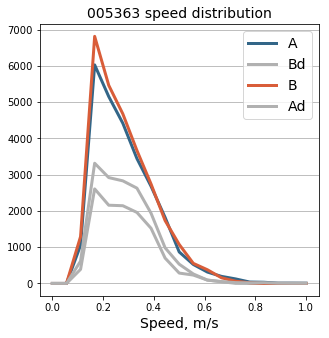

In [41]:
animal = '005363'
exp_type = 'P'
selection = df[(df['animal']==animal) & (df['exp']==exp_type)]
conditions = selection['condition'].unique()
        
fig = figure(figsize=(5, 5))
ax = fig.add_subplot(111)
for q, cond in enumerate(conditions):
    data = selection[selection['condition']==cond]
    dist = np.array([x for x in data['velocity_hist']])
    dist_avg = dist.sum(axis=0)/len(dist)
    ax.plot(np.linspace(0, 1, len(dist_avg)), dist_avg, lw=3, color=colors[cond], label=cond)
ax.set_title('%s speed distribution' % animal, fontsize=14)
ax.set_xlabel('Speed, m/s', fontsize=14)
ax.yaxis.grid()
ax.legend(loc='upper right', fontsize=14)      